In [1]:
import torch
import torch.nn as nn 
import pandas as pd
import numpy as np
import time
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import datetime
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

In [2]:
from src.algorithms.TanoGan import TanoGan
from src.utils.util import *
from src.dataset.swat import SwatDataset
from src.model.modelTanoGan import *
from src.utils.timeseries_anomalies import _fixed_threshold,_find_threshold

In [3]:
#This is the beginning of programm
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)
    

03:05:26


<h4>Initializing Dataset</h4>

In [4]:
seed=0
swat = SwatDataset(seed)

In [5]:
x_train, y_train, x_test, y_test = swat.data()

/home/jupyter/GRANOGAN-IISC/src/dataset/swat.py:142: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df: pd.DataFrame = pd.read_csv(self.raw_path_test)
/home/jupyter/GRANOGAN-IISC/src/dataset/swat.py:143: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df: pd.DataFrame = pd.read_csv(self.raw_path_train)


Total Number of anomalies in train set = 0
Total Number of anomalies in test set = 19271
% of anomalies in the test set = 4.6484421169937935
number of anomalous events = 35


In [6]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(x_train)
x_train = imputer.transform(x_train)

In [7]:
reduced_dimesnion=3
pca = PCA(n_components=reduced_dimesnion, svd_solver='full')
pca.fit(x_train)
x_train=pca.transform(x_train)

In [8]:
pca = PCA(n_components=reduced_dimesnion, svd_solver='full')
pca.fit(x_test)
x_test=pca.transform(x_test)

In [6]:
sequences,y_train_per_window = get_sub_seqs(x_train,y_train, seq_len=60, stride=1,
                                 start_discont=np.array([]))

In [7]:
train_loader, train_val_loader = get_train_data_loaders(sequences, batch_size=32,
                                                                splits=[1 - 0.2,
                                                                        0.2], seed=0)

In [8]:
reduced_dimesnion=51
window_length=60
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = window_length # sequence length is equal to the window length
in_dim = reduced_dimesnion # input dimension is same as number of feature
n_features=reduced_dimesnion

In [9]:
class ArgsTrn:
    workers=4
    batch_size=32
    epochs=5
    lr=0.0002
    cuda = True
    manualSeed=2
    mean=0
    std=0.1
    
opt_trn=ArgsTrn()
torch.manual_seed(opt_trn.manualSeed)

In [10]:
embedding_dim=16
tanoGan=TanoGan(device=device,opt_trn=opt_trn,windows_length=seq_len,n_features=n_features,embedding_dim=embedding_dim)

In [11]:
trained_D,trained_G=tanoGan.train_TanoGAN(train_loader)

/home/jupyter/GRANOGAN-IISC/src/algorithms/TanoGan.py:72: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,self.in_dim),mean=0,std=0.1)).to(self.device)
/home/jupyter/GRANOGAN-IISC/src/algorithms/TanoGan.py:88: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,self.in_dim),mean=0,std=0.1)).to(self.device)


Completed epoch 0
Completed epoch 1
Completed epoch 2
Completed epoch 3
Completed epoch 4


In [12]:
PATH_D='/home/jupyter/GRANOGAN-IISC/src/saved_models/tanogan/swat/dicriminator.pkl'
PATH_G='/home/jupyter/GRANOGAN-IISC/src/saved_models/tanogan/swat/generator.pkl'

In [13]:
torch.save(trained_D.module.state_dict(), PATH_D)
torch.save(trained_G.module.state_dict(), PATH_G)

In [14]:
state_dict = torch.load(PATH_D)
trained_D=LSTMDiscriminator(in_dim=in_dim,device=device)
trained_D=nn.DataParallel(trained_D)
trained_D.to(device)
trained_D=tanoGan.load_model(state_dict,trained_D)

state_dict = torch.load(PATH_G)
trained_G=LSTMGenerator(in_dim=in_dim, out_dim=in_dim,device=device)
trained_G=nn.DataParallel(trained_G)
trained_G.to(device)
trained_G=tanoGan.load_model(state_dict,trained_G)

<h4>Loading back the saved models</h4>

In [15]:
tanoGan.intilialize_D(trained_D)
tanoGan.intilialize_G(trained_G)

<h2>Testing for anomaly</h2>


In [16]:
sequences,y_test_per_window = get_sub_seqs(x_test,y_test, seq_len=60, stride=60, start_discont=np.array([]))
test_loader = DataLoader(dataset=sequences, batch_size=1,  num_workers=4,
                                 shuffle=False)

In [17]:
losses=tanoGan.predict_loss(test_loader)

/home/jupyter/GRANOGAN-IISC/src/algorithms/TanoGan.py:118: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  z = Variable(init.normal(torch.zeros(batch_size,
/libraries/Default_env_55760/lib/python3.8/site-packages/torch/nn/parallel/comm.py:231: UserWarning: Using -1 to represent CPU tensor is deprecated. Please use a device object or string instead, e.g., "cpu".
  warnings.warn(


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

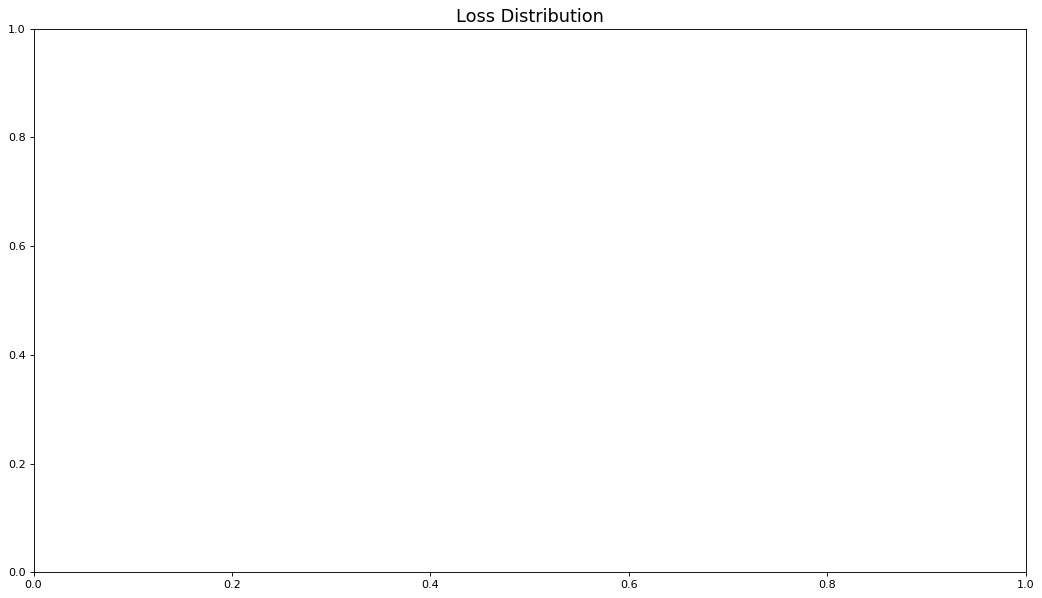

In [19]:
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot(losses, bins = 20, kde= False, color = 'blue');
#sns.distplot(losses, bins = 20, kde= True, color = 'blue');

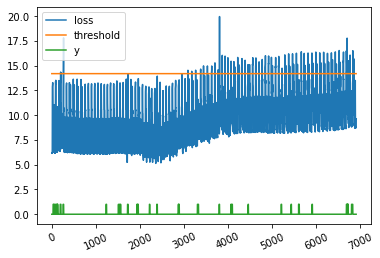

In [48]:
THRESHOLD =14.2


test_score_df = pd.DataFrame(index=range(len(losses)))
test_score_df['loss'] = [loss.item()/60 for loss in losses]
test_score_df['y'] = y_test_per_window
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
#test_score_df['t'] = [x[59].item() for x in sequences]

plt.plot( test_score_df.loss, label='loss')
plt.plot( test_score_df.threshold, label='threshold')
plt.plot( test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();

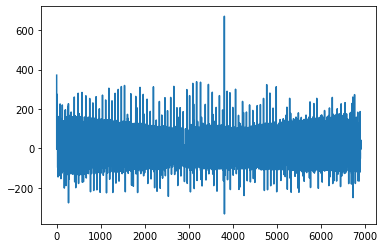

In [53]:
diff = list()
perv_Value=0
for loss in losses:
    value = loss.item() - perv_Value
    perv_Value=loss.item()
    diff.append(value)
plt.plot(diff)
plt.show()

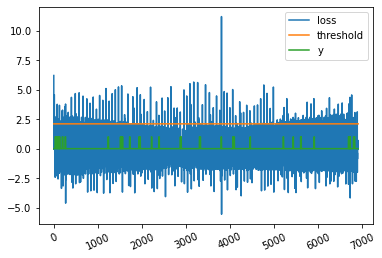

In [79]:
THRESHOLD =2.1

test_score_df = pd.DataFrame(index=range(len(diff)))
test_score_df['loss'] = [loss/60 for loss in diff]
test_score_df['y'] = y_test_per_window
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
#test_score_df['t'] = [x[59].item() for x in sequences]

plt.plot( test_score_df.loss, label='loss')
plt.plot( test_score_df.threshold, label='threshold')
plt.plot( test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();

In [80]:
import numpy as np
actual,predicted=improve_detection(test_score_df)

In [81]:

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

predicted = np.array(predicted)
actual = np.array(actual)

print_scores(predicted,actual)

True Positive	 233
True Negative	 6310
False Positive	 242
False Negative	 124
Accuracy	 0.9470256187581415
Precision	 0.4905263157894737
Recall	 0.6526610644257703
f-measure	 0.560096153846154
cohen_kappa_score	 0.5325144228156131
auc	 0.8078628887452417
roc_auc	 0.8078628887452417
